# Notebook Approche Non Supervisée

In [63]:
from sklearn.ensemble import RandomForestClassifier
import mlflow
import mlflow.sklearn
import pandas as pd
import spacy
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import time


def create_confusion_matrix(conf_matrix, path):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Combined Pipeline')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(path)
    plt.show()


def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_params):
    with mlflow.start_run():
        # Paramètres du modèle
        for key, value in model_params.items():
            mlflow.log_param(key, value)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")

def train_and_evaluate(X, y):
    mlflow.start_run()
    param_max_depth = 10
    param_n_estimators = 100

    # Enregistrez les paramètres
    mlflow.log_param("max_depth", param_max_depth)
    mlflow.log_param("n_estimators", param_n_estimators)

    model = RandomForestClassifier(max_depth=param_max_depth, n_estimators=param_n_estimators)
    model.fit(X, y)
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(model, "model")
    mlflow.end_run()

def evaluate_and_log_metrics(experiment_name, model_name, model_type, y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')

    with mlflow.start_run():
        mlflow.set_experiment(experiment_name)
        mlflow.log_param("model_type", model_type)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        # Enregistrer le modèle dans le registre MLFlow
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
        mlflow.register_model(model_uri, model_name)
        
        # Passer le modèle en staging
        switch_model_to_staging(mlflow, model_name)
    return accuracy, precision, recall, f1

def switch_model_to_staging(mlflow, model_name):
    client = mlflow.tracking.MlflowClient()
    model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
    
    client.transition_model_version_stage(
        name=model_name,
        version=model_version_details.version,
        stage="Staging"
    )

import matplotlib.pyplot as plt

def plot_monthly_metrics(accuracies, precisions, recalls, f1_scores, months, file_path):
    plt.figure(figsize=(12, 6))
    plt.plot(months, accuracies, label='Accuracy', marker='o')
    plt.plot(months, precisions, label='Precision', marker='s')
    plt.plot(months, recalls, label='Recall', marker='^')
    plt.plot(months, f1_scores, label='F1 Score', marker='d')

    plt.xlabel('Months')
    plt.ylabel('Metrics')
    plt.title('Monthly Performance Metrics')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()
    plt.close()


In [64]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("dataset_cleaned.csv")

# Assurez-vous que 'creationdate' est une date
data['creationdate'] = pd.to_datetime(data['creationdate'])

train_data, test_data = train_test_split(data, test_size=0.3)

print(len(test_data))
print(len(train_data))

# Filtrage des données de test
train_data_filtered = train_data[train_data['creationdate'] < pd.Timestamp('2023-01-01')]

# Filtrage des données de test
test_data_filtered = test_data[test_data['creationdate'] < pd.Timestamp('2023-01-01')]

X_train = train_data_filtered[['title_lemmatized', 'body_lemmatized', 'creationdate']]
y_train_original = train_data_filtered['tags_transformed']

X_test = test_data_filtered[['title_lemmatized', 'body_lemmatized', 'creationdate']]
y_test_original = test_data_filtered['tags_transformed']

13609
31753


## MultiLabelBinarizer (Pour Entrainer le modèle sur les 100 tags les plus fréquents)

In [65]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from collections import Counter

y_train_lists = [tags_str.split(',') for tags_str in y_train_original]
y_test_lists = [tags_str.split(',') for tags_str in y_test_original]
tag_counts = Counter(tag for tags_list in y_train_lists for tag in tags_list)

# Garder les 100 tags les plus fréquents
N = 100
top_tags = [tag for tag, _ in tag_counts.most_common(N)]

# Convertir les listes de tags en représentation binaire
mlb = MultiLabelBinarizer(classes=top_tags)
y_train = mlb.fit_transform(y_train_lists)
y_test = mlb.transform(y_test_lists)

print(y_train.shape)
print(y_test.shape)

(31717, 100)
(13593, 100)


/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.a', '.app', '.d.ts', '.doc', '.hgtags', '.htaccess', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.5', '.net-4.6', '.net-4.8', '.net-5', '.net-6.0', '.net-7.0', '.net-assembly', '.net-attributes', '.net-core', '.net-core-2.0', '.net-core-2.1', '.net-core-2.2', '.net-core-3.0', '.net-core-3.1', '.net-core-logging', '.net-core-rc1', '.net-core-rc2', '.net-framework-version', '.net-internals', '.net-mac', '.net-standard', '.net-standard-1.5', '.net-standard-2.0', '.net-standard-2.1', '.netrc', '.profile', '.so', '128-bit', '16-bit', '2-way-object-databinding', '2d', '3-tier', '32-bit', '32bit-64bit', '3d', '3d-modelling', '3d-reconstruction', '3des', '3g', '64-bit', '7zip', 'a-star', 'aac', 'aapt', 'aar', 'abaddressbook', 'abap', 'abbreviation', 'abcl', 'abi', 'abort', 'abrecord', 'absl-py', 'absolute', 'absolute-path', 'absolute-value', 'abstract'

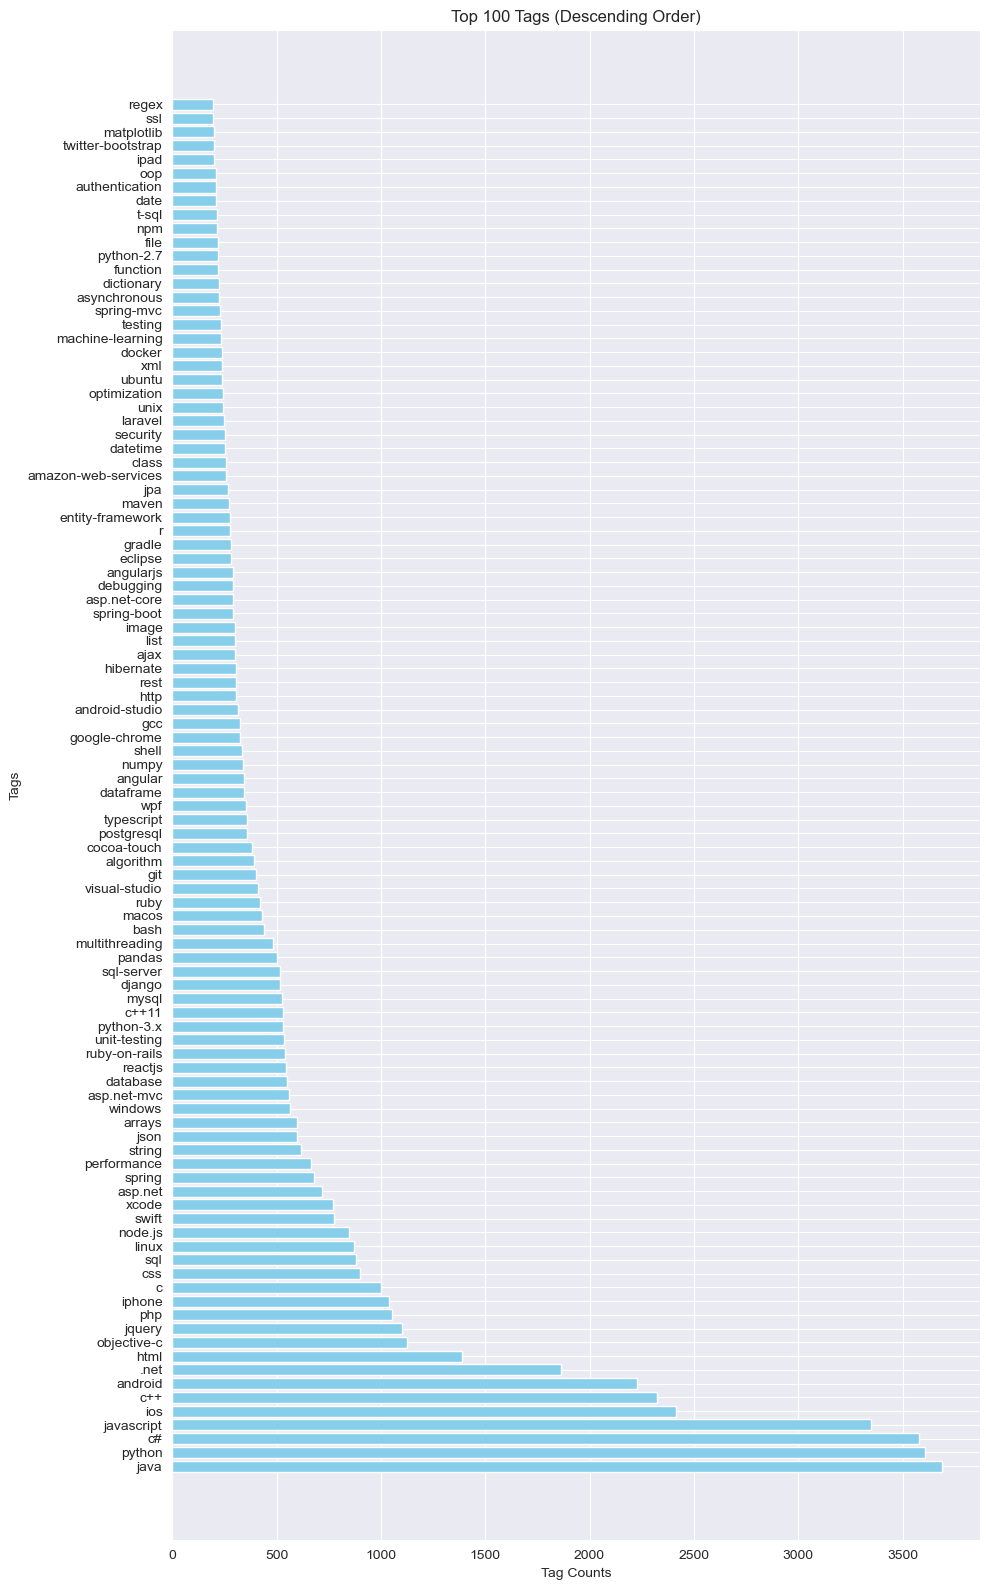

In [66]:
import matplotlib.pyplot as plt
from collections import Counter

top_tag_counts = Counter(tag for tags_list in y_train_lists for tag in tags_list if tag in top_tags)
top_tag_names, top_tag_counts = zip(*top_tag_counts.items())

sorted_indices = sorted(range(len(top_tag_counts)), key=lambda k: top_tag_counts[k], reverse=True)
top_tag_names = [top_tag_names[i] for i in sorted_indices]
top_tag_counts = [top_tag_counts[i] for i in sorted_indices]

plt.figure(figsize=(10, 16))
plt.barh(top_tag_names, top_tag_counts, color='skyblue')
plt.xlabel('Tag Counts')
plt.ylabel('Tags')
plt.title('Top {} Tags (Descending Order)'.format(N))
plt.tight_layout()

plt.show()


## CountVectorizer

### Train OneVsRestClassifier

In [67]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

title_classifier = MultinomialNB()
body_classifier = MultinomialNB()
combined_classifier = MultinomialNB()

titleOneRestclassifier = OneVsRestClassifier(title_classifier)
bodyOneRestclassifier = OneVsRestClassifier(body_classifier)
combinedOneRestclassifier = OneVsRestClassifier(combined_classifier)

title_pipeline = Pipeline([
    ('vectorizer_title', CountVectorizer()),
    ('classifier', titleOneRestclassifier)
])

body_pipeline = Pipeline([
    ('vectorizer_body', CountVectorizer()),
    ('classifier', bodyOneRestclassifier)
])

combined_pipeline = Pipeline([
    ('vectorizer_combined', CountVectorizer()),
    ('classifier', combinedOneRestclassifier)
])

X_train_combined = X_train['title_lemmatized'] + ' ' + X_train['body_lemmatized']
X_test_combined = X_test['title_lemmatized'] + ' ' + X_test['body_lemmatized']

title_pipeline.fit(X_train['title_lemmatized'], y_train)
body_pipeline.fit(X_train['body_lemmatized'], y_train)
combined_pipeline.fit(X_train_combined, y_train)

Pipeline(steps=[('vectorizer_combined', CountVectorizer()),
                ('classifier', OneVsRestClassifier(estimator=MultinomialNB()))])

### Predict OneVsRestClassifier

In [68]:
import numpy as np

X_title_test_transformed = title_pipeline.named_steps['vectorizer_title'].transform(X_test['title_lemmatized'])
X_body_test_transformed = body_pipeline.named_steps['vectorizer_body'].transform(X_test['body_lemmatized'])
X_combined_test_transformed = combined_pipeline.named_steps['vectorizer_combined'].transform(X_test_combined)

predictions_proba_title = title_pipeline.predict_proba(X_test['title_lemmatized'])
predictions_proba_body = body_pipeline.predict_proba(X_test['body_lemmatized'])
predictions_proba_combined = combined_pipeline.predict_proba(X_test_combined)

n_top_classes = 5

top_classes_indices_title = np.argsort(predictions_proba_title)[:, -n_top_classes:]
top_classes_indices_body = np.argsort(predictions_proba_body)[:, -n_top_classes:]
top_classes_indices_combined = np.argsort(predictions_proba_combined)[:, -n_top_classes:]

top_tags_title = mlb.classes_[top_classes_indices_title]
top_tags_body = mlb.classes_[top_classes_indices_body]
top_tags_combined = mlb.classes_[top_classes_indices_combined]


## Sauvegarde du modèle

In [69]:
from joblib import dump

dump(combined_pipeline, 'model_supervised_OneVsRestClassifier_MultinomialNB.joblib')

dump(mlb, 'model_supervised_MultinomialNB.joblib')

['model_supervised_MultinomialNB.joblib']

## Récupérer les tags les plus proches (en utilisant predict_proba)

In [70]:
# Liste des questions à prédire (title + body)
questions_to_predict = ["How can you implement a thread-safe singleton in Java?", "#*Whatnot** is a livestream shopping platform and marketplace backed by Andreessen Horowitz, Y Combinator, and CapitalG. We’re building the future of ecommerce, bringing together community, shopping and entertainment. We are committed to our values, whether working remotely or from one of our offices. We are building a team that has experience from top tech, retail and payments platforms in the world. We’re innovating in the fast-paced world of live auctions in categories including sports, fashion, video games, and streetwear. The platform couples rigorous seller vetting with a focus on community to create a welcoming space for buyers and sellers to share their passions with others. And, we’re growing. Whatnot has been the fastest growing marketplace in the US over the past two years and we’re hiring forward-thinking problem solvers across all functional areas. Retail disruption is one of the largest opportunities in the startup space today. Livestream shopping is taking off around the world – a $300B GMV market in China that’s grown 100% YoY. Whatnot is bringing it to the world through a community-first approach, starting in the U.S. where retail is a $5T market opportunity! We are looking for intellectually curious, highly motivated individuals to join us for a 12-week remote internship during summer 2024. Our interns work in cross-functional multidisciplinary teams enabling you to directly impact the direction of our platform. Your code and ideas will contribute to solving some of the most complex technical challenges we face today and define future engineering initiatives.    - Building new features for users in our live-streams - Implementing growth tactics and strategies to scale our buyer and seller flows - Building systems at scale that help us deliver a high trust marketplace experience By the end of your internship, you will have contributed to one of the fastest growing marketplaces ever while gaining core industry skills of project ideation, management and collaboration Curious about who thrives at Whatnot? We’ve found that low ego, a growth mindset, and leaning into action and high impact goes a long way here. As our next Engineering Intern you should have some industry software engineering experience, plus: - Pursuing a degree in computer science or other related major graduating in 2025 - Problem solver and out-of-the-box thinker - Willing to take risks and build product and systems for 1M+ users    - Ability to pick up on new technologies quickly"]

predictions_proba_combined_multiple = combined_pipeline.predict_proba(questions_to_predict)
n_top_classes = 5

# itérer sur chaque prédiction
for i, question in enumerate(questions_to_predict):
    top_classes_indices = predictions_proba_combined_multiple.argsort(axis=1)[:, -n_top_classes:][i]
    top_classes_probabilities = predictions_proba_combined_multiple[i, top_classes_indices]

    # Tri des classes et des probabilités par ordre décroissant de probabilité
    sorted_indices = np.argsort(top_classes_probabilities)[::-1]
    top_tags_combined_sorted = mlb.classes_[top_classes_indices[sorted_indices]]
    top_classes_probabilities_sorted = top_classes_probabilities[sorted_indices]

    print(f"Tags associés pour la question '{question}':", list(zip(top_tags_combined_sorted, top_classes_probabilities_sorted)))
    print("\n")


Tags associés pour la question 'How can you implement a thread-safe singleton in Java?': [('java', 0.8615892364095805), ('multithreading', 0.033198161266009926), ('c#', 0.015997921597052617), ('c++', 0.007870999880669477), ('.net', 0.0029077181625624077)]


Tags associés pour la question '#*Whatnot** is a livestream shopping platform and marketplace backed by Andreessen Horowitz, Y Combinator, and CapitalG. We’re building the future of ecommerce, bringing together community, shopping and entertainment. We are committed to our values, whether working remotely or from one of our offices. We are building a team that has experience from top tech, retail and payments platforms in the world. We’re innovating in the fast-paced world of live auctions in categories including sports, fashion, video games, and streetwear. The platform couples rigorous seller vetting with a focus on community to create a welcoming space for buyers and sellers to share their passions with others. And, we’re growing

## Évaluation du modèle de référence

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

top_tags_title_predicted = mlb.transform(top_tags_title)
top_tags_body_predicted = mlb.transform(top_tags_body)
top_tags_combined_predicted = mlb.transform(top_tags_combined)
experiment_name = 'supervised OneVsRestClassifier MultinomialNB'
model_name = 'supervised OneVsRestClassifier MultinomialNB'

# Evaluation and logging for the title pipeline
accuracy_title, precision_title, recall_title, f1_title = evaluate_and_log_metrics(experiment_name, model_name, "title", y_test, top_tags_title_predicted)
print("\nTitle Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_title)
print("Precision:", precision_title)
print("Recall:", recall_title)
print("F1 Score:", f1_title)

# Evaluation and logging for the body pipeline
accuracy_body, precision_body, recall_body, f1_body = evaluate_and_log_metrics(experiment_name, model_name, "body", y_test, top_tags_body_predicted)
print("\nBody Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_body)
print("Precision:", precision_body)
print("Recall:", recall_body)
print("F1 Score:", f1_body)

# Evaluation and logging for the combined pipeline
accuracy_combined, precision_combined, recall_combined, f1_combined = evaluate_and_log_metrics(experiment_name, model_name, "combined", y_test, top_tags_combined_predicted)
print("\nCombined Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_combined)
print("Precision:", precision_combined)
print("Recall:", recall_combined)
print("F1 Score:", f1_combined)


Exception: '/Users/flo/workspace/Catégorisez automatiquement des questions/models/mlruns' does not exist.

## Évaluations du modèle par mois

- Période de références, toutes les données avant jusqu'à fin décembre 2022.
- On entraine le modèle une seule fois sur la période de référence.
- On compare les résultats du modèle par mois (chaque mois de 2023) par rapport aux résultats de référence.

### Creation de monthly_test_data avec les données de chaque mois

In [ ]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("dataset_cleaned.csv")

# Assurez-vous que 'creationdate' est une date
data['creationdate'] = pd.to_datetime(data['creationdate'])

# Filtrage des données de test
test_data_only_2023 = data[data['creationdate'] >= pd.Timestamp('2023-01-01')]

test_data_only_2023.to_csv("dataset_over_months_2023.csv", index=False)


In [ ]:
print(len(test_data_only_2023))
monthly_test_data = {}
for month in range(1, 13):
    monthly_data = test_data_only_2023[test_data_only_2023['creationdate'].dt.year == 2023]
    monthly_data = monthly_data[monthly_data['creationdate'].dt.month == month]

    if not monthly_data.empty:
        monthly_test_data[month] = monthly_data

for month, data in monthly_test_data.items():
    print(f"Nombre de lignes pour le mois {month}: {len(data)}")


### Prédiction sur chaque mois

In [ ]:
import numpy as np
import calendar

n_top_classes = 5
accuracy_combined = []
precision_combined = []
recall_combined = []
f1_combined = []
months = []

for month, X_test_month in monthly_test_data.items():
    month_name = calendar.month_name[month]
    months.append(month_name)
    experiment_name = f"{month_name} 2023 - supervised OneVsRestClassifier MultinomialNB"
    model_name = "supervised OneVsRestClassifier MultinomialNB"

    # Préparation des données combinées pour le mois
    X_test_combined_month = X_test_month['title_lemmatized'] + ' ' + X_test_month['body_lemmatized']
    y_test_lists = [tags_str.split(',') for tags_str in X_test_month['tags_transformed']]
    y_test_month = mlb.transform(y_test_lists)
    
    # Prédiction avec le modèle de référence (en utilisant predict_proba)
    predictions_proba_combined = combined_pipeline.predict_proba(X_test_combined_month)
    top_classes_indices_combined = np.argsort(predictions_proba_combined)[:, -n_top_classes:]
    top_tags_combined = mlb.classes_[top_classes_indices_combined]
    top_tags_combined_predicted = mlb.transform(top_tags_combined)

    # Évaluation des performances pour le mois
    accuracy_combined_month, precision_combined_month, recall_combined_month, f1_combined_month = evaluate_and_log_metrics(
        experiment_name, model_name, f"combined_{month}", y_test_month, top_tags_combined_predicted)

    accuracy_combined.append(accuracy_combined_month)
    precision_combined.append(precision_combined_month)
    recall_combined.append(recall_combined_month)
    f1_combined.append(f1_combined_month)

    # Affichage des métriques pour le mois
    print(f"\nCombined Pipeline Metrics for {month_name}:")
    print("Accuracy:", accuracy_combined_month)
    print("Precision:", precision_combined_month)
    print("Recall:", recall_combined_month)
    print("F1 Score:", f1_combined_month)


## Graph de l'évolution du score à travers les mois

In [ ]:
plot_monthly_metrics(accuracy_combined, precision_combined, recall_combined, f1_combined, months, 'scoring_over_time.png')

## Tests unitaires

import numpy as np
import unittest
from unittest.mock import patch, MagicMock
import mlflow
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming your functions are defined as above

class TestMLflowFunctions(unittest.TestCase):
    @patch('__main__.switch_model_to_staging')
    @patch('mlflow.register_model')
    @patch('mlflow.start_run')
    @patch('mlflow.active_run')
    def test_evaluate_and_log_metrics(self, mock_active_run, mock_start_run, mock_register_model, mock_switch_model_to_staging):
        y_test = np.random.randint(0, 2, 20)
        y_predicted = np.random.randint(0, 2, 20)
    
        # Setting up the mock for mlflow.start_run
        mock_run = MagicMock()
        mock_run.info.run_id = "mock_run_id"
        mock_start_run.return_value.__enter__.return_value = mock_run
        mock_active_run.return_value = mock_run
    
        accuracy, precision, recall, f1 = evaluate_and_log_metrics("experiment_name", "model_name", "model_type", y_test, y_predicted)
    
        # Assertions
        mock_start_run.assert_called_once()
        mock_register_model.assert_called_with(f"runs:/mock_run_id/model", "model_name")
        self.assertEqual(accuracy, accuracy_score(y_test, y_predicted))
        self.assertEqual(precision, precision_score(y_test, y_predicted, average='weighted'))
        self.assertEqual(recall, recall_score(y_test, y_predicted, average='weighted'))
        self.assertEqual(f1, f1_score(y_test, y_predicted, average='weighted'))


    @patch('mlflow.tracking.MlflowClient')
    def test_switch_model_to_staging(self, mock_mlflow_client):
        # Mock the MLflowClient and its method
        mock_client = MagicMock()
        mock_mlflow_client.return_value = mock_client
    
        # Create a mock model version object
        mock_model_version = MagicMock()
        mock_model_version.version = '1'
    
        # Configure get_latest_versions to return a list with the mock model version
        mock_client.get_latest_versions.return_value = [mock_model_version]
    
        # Call the function
        switch_model_to_staging(mlflow, "model_name")
    
        # Assertions
        mock_mlflow_client.assert_called_once()
        mock_client.get_latest_versions.assert_called_with("model_name", stages=["None"])
        mock_client.transition_model_version_stage.assert_called_once_with(name="model_name", version='1', stage="Staging")


unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestMLflowFunctions))
